In [1]:
#importing libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
data = pd.read_csv("loan.csv")

C:\Users\Tomiwa Adeleke\AppData\Local\Temp\ipykernel_14480\2900409819.py:1: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("loan.csv")


In [3]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.dtypes

id                       float64
member_id                float64
loan_amnt                  int64
funded_amnt                int64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 145, dtype: object

In [5]:
data.isnull().sum()

id                       2260668
member_id                2260668
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_status        2227612
settlement_date          2227612
settlement_amount        2227612
settlement_percentage    2227612
settlement_term          2227612
Length: 145, dtype: int64

In [6]:
data.shape

(2260668, 145)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [8]:
# Glancing through the target variable 
data['loan_status'].value_counts()

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

In [9]:
# filtering unnecessary values in the loan status column
expected_statuses = ['Fully Paid', 'Charged Off', 'Default']
data = data[data['loan_status'].isin(expected_statuses)]
data['loan_status'].value_counts()

loan_status
Fully Paid     1041952
Charged Off     261655
Default             31
Name: count, dtype: int64

In [10]:
#creating binary target
data['target_default'] = data['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0
)
#Verify class balance
data['target_default'].value_counts(normalize=True)

target_default
0    0.799265
1    0.200735
Name: proportion, dtype: float64

In [11]:
#removing data leakage features because they contain post loan repayment information
leakage_cols = [
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv', 
    'last_credit_pull_d', 
    'debt_settlement_flag',
    'mths_since_recent_bc',
    'mths_since_recent_bc_dlq',
    'mths_since_recent_revol_delinq',
    'mths_since_recent_inq',
    'mths_since_last_major_derog',
    'collections_12_mths_ex_med',
    'pub_rec_bankruptcies',
    'mths_since_last_delinq_flag',
    'mths_since_last_major_derog_flag',
    'mths_since_recent_bc_dlq_flag',
    'mths_since_recent_revol_delinq_flag'
]
data = data.drop(columns=leakage_cols, errors='ignore')

In [12]:
#dropping loan staus column because i have extracted target default seperately
data = data.drop(columns=['loan_status'], errors='ignore')

In [13]:
data.shape

(1303638, 124)

In [14]:
#creating modelling dataset
X = data.drop(columns=['target_default'])
y = data['target_default']

In [15]:
X.isnull().mean().sort_values(ascending=False)

id                                            1.000000
member_id                                     1.000000
url                                           1.000000
orig_projected_additional_accrued_interest    0.997367
hardship_length                               0.995908
                                                ...   
open_acc                                      0.000000
pub_rec                                       0.000000
revol_bal                                     0.000000
delinq_amnt                                   0.000000
application_type                              0.000000
Length: 123, dtype: float64

In [16]:
#dropping missing values
drop_full_missing = [
    'id',
    'member_id',
    'url',
]

X = X.drop(columns=drop_full_missing, errors='ignore')


In [17]:
#dropping irrelevant column
missing_threshold = 0.95
high_missing_cols = X.columns[X.isnull().mean() >= missing_threshold]

X = X.drop(columns=high_missing_cols)


In [18]:
X.isnull().mean().sort_values(ascending=False).head(20)

desc                      0.905399
mths_since_last_record    0.829881
il_util                   0.668087
mths_since_rcnt_il        0.626753
all_util                  0.616822
total_cu_tl               0.616784
open_acc_6m               0.616784
inq_last_12m              0.616784
inq_fi                    0.616783
max_bal_bc                0.616783
open_rv_24m               0.616783
open_rv_12m               0.616783
open_il_24m               0.616783
open_il_12m               0.616783
open_act_il               0.616783
total_bal_il              0.616783
mths_since_last_delinq    0.504613
num_tl_120dpd_2m          0.088653
mo_sin_old_il_acct        0.080003
emp_title                 0.063347
dtype: float64

In [19]:
#dropping missing values
drop_full_missing = [
    'desc',
    'mths_since_last_record'
]

X = X.drop(columns=drop_full_missing, errors='ignore')


In [20]:
#handling other missing values
cols = ['mths_since_last_delinq','mths_since_rcnt_il']

for col in cols:
    X[col + '_flag'] = X[col].notnull().astype(int)
X[cols] = X[cols].fillna(999)


In [21]:
#handling other missing values
activity_cols = [
    'all_util','total_cu_tl','open_acc_6m','inq_last_12m',
    'open_act_il','total_bal_il','open_il_12m','open_il_24m',
    'inq_fi','open_rv_24m','open_rv_12m','max_bal_bc','il_util'
]

X[activity_cols] = X[activity_cols].fillna(0)


In [22]:
X.isnull().mean().max()


0.08865267812076666

In [23]:
# Converting earliest credit line date into length of credit history (in years)
# Credit history length is more predictive than raw dates for default modeling
X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], errors='coerce')

X['credit_history_years'] = (
    pd.to_datetime('today') - X['earliest_cr_line']
).dt.days / 365

X = X.drop(columns=['earliest_cr_line'])


C:\Users\Tomiwa Adeleke\AppData\Local\Temp\ipykernel_14480\1696380092.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], errors='coerce')


In [24]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical features: {len(cat_cols)}")
print(f"Numeric features: {len(num_cols)}")

Categorical features: 17
Numeric features: 69


In [25]:
y.value_counts(normalize=True)

target_default
0    0.799265
1    0.200735
Name: proportion, dtype: float64

In [26]:
#reducing High-Cardinality Categorical Variables
def reduce_cardinality(series, top_n=20):
    # Identifying the most frequent categories
    top_categories = series.value_counts().nlargest(top_n).index
    # Replacing rare categories with 'Other'
    return series.where(series.isin(top_categories), other='Other')
# Applying  cardinality reduction only to categorical columns with too many unique values
for col in cat_cols:
    if X[col].nunique() > 30:
        X[col] = reduce_cardinality(X[col], top_n=20)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [28]:
#Preprocessing Pipeline
# Pipeline for numeric features
# Median is robust to outliers (important in financial data)
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [29]:
# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    # Replace missing values with the most frequent category
    ('imputer', SimpleImputer(strategy='most_frequent')),
# One-hot encode categorical variables
# - drop='first' avoids multicollinearity
# - handle_unknown='ignore' prevents errors on unseen categories
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [30]:
# Apply numeric and categorical pipelines to their respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ]
)

#### EDA

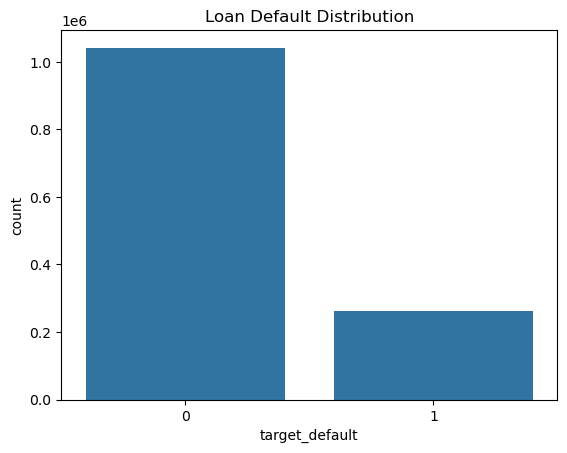

target_default
0    0.799265
1    0.200735
Name: proportion, dtype: float64

In [31]:
# Visualizing class distribution
sns.countplot(x=y)
plt.title("Loan Default Distribution")
plt.show()


# View proportion of defaults vs non-defaults
y.value_counts(normalize=True)

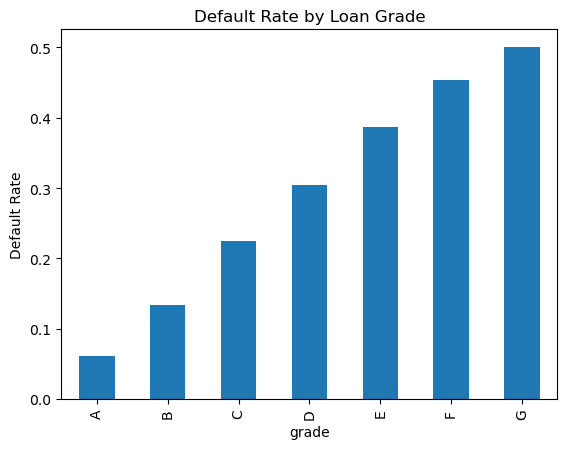

In [32]:
# Calculating default rate per loan grade
grade_default = data.groupby('grade')['target_default'].mean().sort_index()

# Plot default rate by grade
grade_default.plot(kind='bar')
plt.ylabel("Default Rate")
plt.title("Default Rate by Loan Grade")
plt.show()

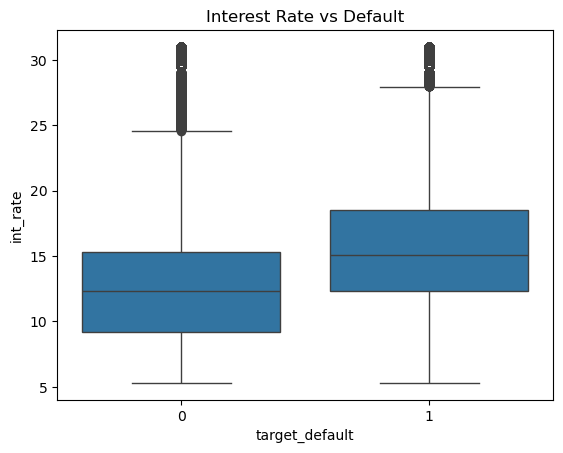

In [33]:
# Comparing interest rates for defaulters vs non-defaulters
sns.boxplot(x='target_default', y='int_rate', data=data)
plt.title("Interest Rate vs Default")
plt.show()

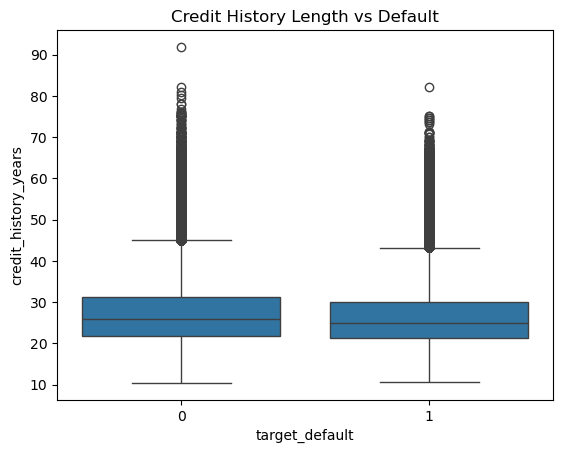

In [34]:
# Analyze relationship between credit history length and default
# Combine feature and target temporarily for EDA
eda_df = X.copy()
eda_df['target_default'] = y

# Plot credit history length vs default
sns.boxplot(
    x='target_default',
    y='credit_history_years',
    data=eda_df
)
plt.title("Credit History Length vs Default")
plt.show()

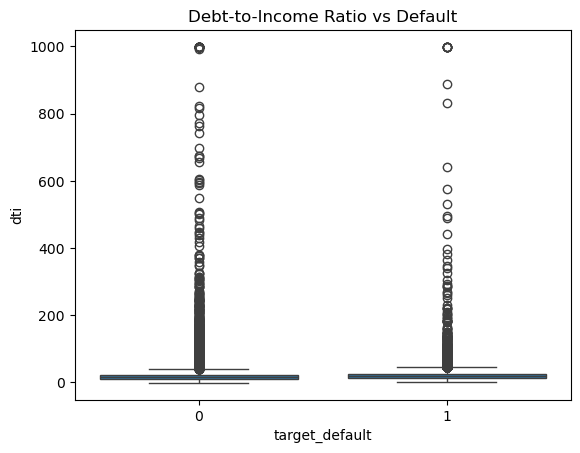

In [35]:
#Debt-to-Income Ratio vs Default
#Examine how debt burden relates to default risk
sns.boxplot(x='target_default', y='dti', data=data)
plt.title("Debt-to-Income Ratio vs Default")
plt.show()

### Modeling

In [36]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score,classification_report,confusion_matrix,roc_curve,precision_recall_curve)
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
import shap

In [38]:
# Creating logistic regression model
log_reg = LogisticRegression(
    max_iter=1000,          # ensure convergence
    class_weight='balanced',
    solver='lbfgs'
)

# Full modeling pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # numeric + categorical pipelines
    ('model', log_reg)
])

In [39]:
# Training the logistic regression model
log_reg_pipeline.fit(X_train, y_train)

C:\Users\Tomiwa Adeleke\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
# model predictions
y_pred = log_reg_pipeline.predict(X_test)

# Predicting probabilities (needed for ROC / PR curves)
y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

C:\Users\Tomiwa Adeleke\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Tomiwa Adeleke\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [41]:
# Computing false positive rate, true positive rate, and thresholds
fpr,tpr, thresholds = roc_curve(y_test,y_pred_proba)
# Computing ROC-AUC metric
roc_auc = roc_auc_score(y_test, y_pred_proba)
round(roc_auc,2)

0.65

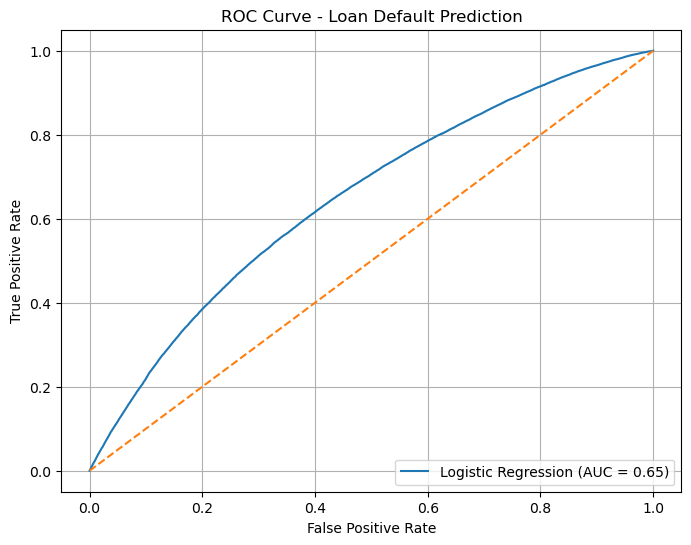

In [42]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label=f"Logistic Regression (AUC ={roc_auc: .2f})")
plt.plot([0,1],[0,1], linestyle='--')
#random classifieer line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Loan Default Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [43]:
# compute Youden's J statistic for each threshold
j_scores = tpr -fpr
# index of the maximum youden's J value
best_idx = np.argmax(j_scores)
# best decision threshold
best_threshold = thresholds[best_idx]
best_threshold

np.float64(0.5051308308000957)

In [44]:
# applying the custom threshold insteadof the default 0.5
y_pred_custom = (y_pred_proba >= best_threshold).astype(int)

In [45]:
# confusion matrix shows prediction errors
conf_matrix =  confusion_matrix(y_test, y_pred_custom)
# classification report gives precision, recall, f1-score
class_report = classification_report(y_test,y_pred_custom)
print("Confusion Matrix")
print(conf_matrix)
print("Classification Report")
print(class_report)

Confusion Matrix
[[128686  79705]
 [ 20990  31347]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.62      0.72    208391
           1       0.28      0.60      0.38     52337

    accuracy                           0.61    260728
   macro avg       0.57      0.61      0.55    260728
weighted avg       0.74      0.61      0.65    260728



In [46]:
# Logistic Regression with class balancing
log_reg_balanced = LogisticRegression(
max_iter=1000,
class_weight='balanced', # Handles class imbalance
solver='lbfgs')

In [47]:
# Full pipeline with preprocessing + balanced logistic regression
log_reg_balanced_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),  # Same ColumnTransformer as before
        ('model', log_reg_balanced)
    ]
)

In [48]:
# Fit the balanced model on training data
log_reg_balanced_pipeline.fit(X_train, y_train)

C:\Users\Tomiwa Adeleke\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [49]:
# Predict probabilities for the positive class (default = 1)
y_proba_balanced = log_reg_balanced_pipeline.predict_proba(X_test)[:, 1]

C:\Users\Tomiwa Adeleke\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [50]:
# Computing false positive rate, true positive rate, and thresholds
fpr_b,tpr_b, thresholds_b = roc_curve(y_test,y_proba_balanced)
# Computing ROC-AUC metric
roc_auc_b = roc_auc_score(y_test, y_proba_balanced)
round(roc_auc_b,2)

0.65

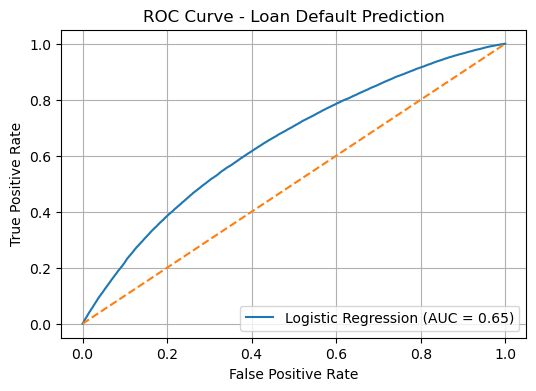

In [51]:
plt.figure(figsize=(6,4))
plt.plot(fpr_b,tpr_b, label=f"Logistic Regression (AUC ={roc_auc_b: .2f})")
plt.plot([0,1],[0,1], linestyle='--')
#random classifieer line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Loan Default Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [52]:
# Compute Youden's J statistic
youden_j_b = tpr_b - fpr_b


# Find optimal threshold
best_index_b = np.argmax(youden_j_b)
best_threshold_b = thresholds_b[best_index_b]


best_threshold_b

np.float64(0.5051308308000957)

In [53]:
# Convert probabilities to predictions using tuned threshold
y_pred_balanced = (y_proba_balanced >= best_threshold_b).astype(int)


# Confusion matrix
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)


# Classification report
class_report_balanced = classification_report(y_test, y_pred_balanced)


# Display results
print("Confusion Matrix (Balanced Logistic Regression):")
print(conf_matrix_balanced)


print("\nClassification Report (Balanced Logistic Regression):")
print(class_report_balanced)

Confusion Matrix (Balanced Logistic Regression):
[[128686  79705]
 [ 20990  31347]]

Classification Report (Balanced Logistic Regression):
              precision    recall  f1-score   support

           0       0.86      0.62      0.72    208391
           1       0.28      0.60      0.38     52337

    accuracy                           0.61    260728
   macro avg       0.57      0.61      0.55    260728
weighted avg       0.74      0.61      0.65    260728



In [54]:
# Recall from original tuned model
recall_original = recall_score(y_test, y_pred_custom)


# Recall from balanced model
recall_balanced = recall_score(y_test, y_pred_balanced)


print("Recall (Original Model):", recall_original)
print("Recall (Balanced Model):", recall_balanced)

Recall (Original Model): 0.598945296826337
Recall (Balanced Model): 0.598945296826337


In [55]:
# Random Forest classifier
# n_estimators: number of trees
# max_depth: prevents overfitting
# class_weight: handle class imbalance
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [56]:
# Pipeline with preprocessing + Random Forest
rf_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', rf_model)
    ]
)

In [57]:
# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
# Predict probability of default
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

C:\Users\Tomiwa Adeleke\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
# Compute ROC-AUC score
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Round for reporting
round(roc_auc_rf, 2)

0.72

In [60]:
# Compute ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)


# Youden's J statistic
youden_j_rf = tpr_rf - fpr_rf


# Optimal threshold
best_idx_rf = np.argmax(youden_j_rf)
best_threshold_rf = thresholds_rf[best_idx_rf]


best_threshold_rf

np.float64(0.4996211045132631)

In [61]:
#creating a cmparison table
model_comparison = pd.DataFrame({"Model": ["Logistic regression","Random Forest"], "ROC-AUC": [round(roc_auc, 2), round(roc_auc_rf, 2)]})
model_comparison

,Model,ROC-AUC
0,Logistic regression,0.65
1,Random Forest,0.72


In [62]:
# Convert probabilities to predictions using tuned threshold
y_pred_rf = (y_proba_rf >= best_threshold_rf).astype(int)


# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)


# Classification report
class_report_balanced = classification_report(y_test, y_pred_rf)


# Display results
print("Confusion Matrix (Random Forest):")
print(conf_matrix_balanced)


print("\nClassification Report (Random Forest):")
print(class_report_balanced)

Confusion Matrix (Random Forest):
[[128686  79705]
 [ 20990  31347]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.88      0.66      0.76    208391
           1       0.33      0.66      0.44     52337

    accuracy                           0.66    260728
   macro avg       0.61      0.66      0.60    260728
weighted avg       0.77      0.66      0.69    260728



In [63]:
 # Extracting features names after preprocessing 
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
#Extracting feature importances;'#]qa][]q]q[[a]

importances = rf_pipeline.named_steps['model'].feature_importances_
#Creating importance dataframe
feature_importance_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(by="importance", ascending=False)

feature_importance_df.head(15)

,feature,importance
3,num__int_rate,0.192316
69,cat__term_ 60 months,0.098207
95,cat__sub_grade_Other,0.073658
72,cat__grade_D,0.043758
70,cat__grade_B,0.039372
73,cat__grade_E,0.030539
6,num__dti,0.030327
34,num__acc_open_past_24mths,0.021851
62,num__tot_hi_cred_lim,0.021284
71,cat__grade_C,0.021029


In [64]:
# Sample data for SHAP 
X_shap_raw = X_test.sample(300, random_state=42)
# Extract fitted preprocessor and model
preprocessor = rf_pipeline.named_steps["preprocessor"]
rf_model = rf_pipeline.named_steps["model"]

# Transform raw data → numeric matrix
X_shap_transformed = preprocessor.transform(X_shap_raw)
# Get feature names after encoding
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame for SHAP plotting
X_shap_df = pd.DataFrame(
    X_shap_transformed,
    columns=feature_names
)


# Create TreeExplainer for Random Forest
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_shap_transformed)

shap_values = explainer.shap_values(X_shap_transformed)

# Handle the list/array output variation
if isinstance(shap_values, list):
    # For binary classification, index 1 is usually the positive class
    shap_values_to_plot = shap_values[1]
else:
    # If it's a 3D array [samples, features, classes]
    if len(shap_values.shape) == 3:
        shap_values_to_plot = shap_values[:, :, 1]
    else:
        shap_values_to_plot = shap_values

# FINAL GUARD: Ensure feature count matches exactly
if shap_values_to_plot.shape[1] > len(feature_names):
    # This trims off the "expected value" / bias column if SHAP included it
    shap_values_to_plot = shap_values_to_plot[:, :len(feature_names)]

print(shap_values_to_plot.shape)
print(X_shap_transformed.shape)

(300, 228)
(300, 228)


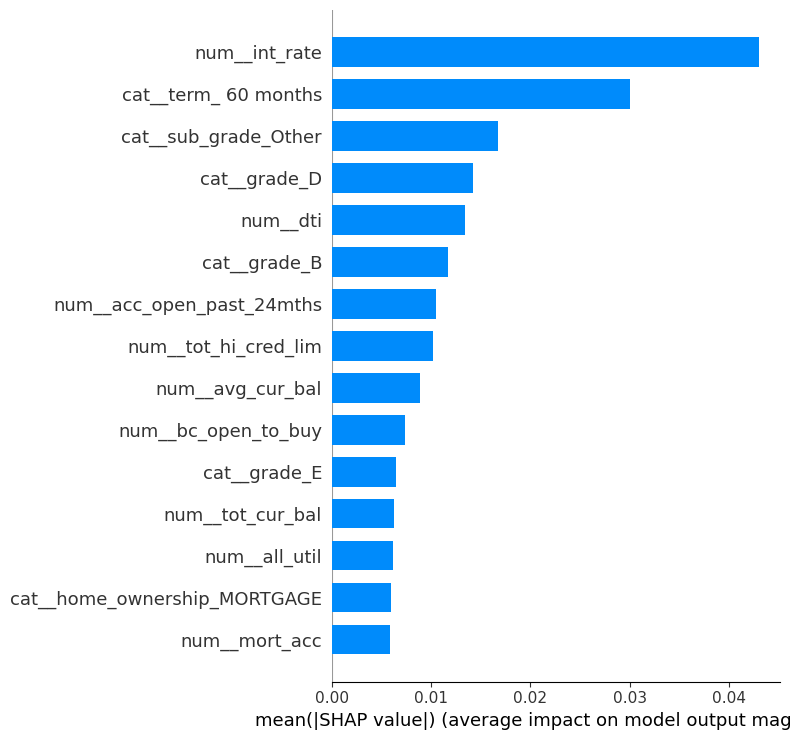

In [65]:
shap.summary_plot(
    shap_values_to_plot,
    X_shap_transformed,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15
)